**Kelompok 10**

Kelas LA01 - Computer Vision - Assignment Image Stitching

Anggota kelompok:
1. 2440087214 - Debora
2. 2440016804 - Rio Pramana

References:
*   https://python.plainenglish.io/opencv-job-application-image-stitching-task-part-1-1cc4799bc0b5
*   https://python.plainenglish.io/opencv-image-stitching-second-part-388784ccd1a
* https://stackoverflow.com/questions/61986407/crop-x-ray-image-to-remove-black-background
* https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87



The explanation for this assignment is provided through text cells and comments in the code cell

For this assignment about image stitching, we need to perform 4 main steps:
1. Detect and compute keypoints and descriptors of the images
2. Get the matches of the descriptors
3. Calculate the homography matrix using RANSAC algorithm
4. Apply warping transformation using the homography matrix

This algorithm is mainly used for stitching 2 images. Because we have 3 images in the assignment, we will perform the image stitching process twice to stitch all 3 images

# Import libraries

In this assignment, we will only be using 4 libraries

In [20]:
#Import libraries
import numpy as np
import cv2
import imutils # For rotating image
from matplotlib import pyplot as plt # For displaying images

# Read and preprocess images

We are assuming the 3 images are in the same folder as the .ipynb file

In [21]:
#Load image from files
img_left = cv2.imread('1a.jpg')
img_centre = cv2.imread('1b.jpg')
img_right = cv2.imread('1c.jpg')

Display the images:

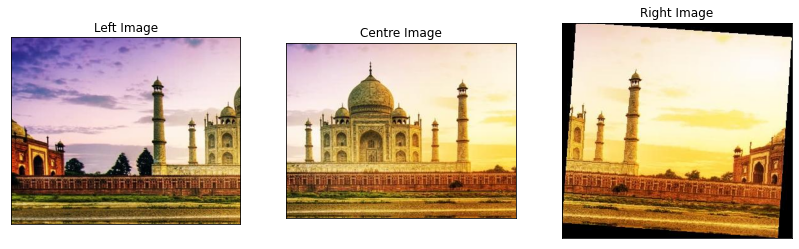

In [22]:
# Display the images
fig = plt.figure(figsize=(14,10))

# We change every image from BGR to RGB because we are displaying..
# ..all images using matplotlib, not opencv

# Left image
plt.subplot(131),plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.title('Left Image'), plt.xticks([]), plt.yticks([])

# Centre image
plt.subplot(132),plt.imshow(cv2.cvtColor(img_centre, cv2.COLOR_BGR2RGB))
plt.title('Centre Image'), plt.xticks([]), plt.yticks([])

# Right image
plt.subplot(133),plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.title('Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

We noticed that the third image is slightly rotated. Therefore, we need to fix the image rotation first before starting the image stitching process

We will use imutils.rotate() to fix the third image with the angle of 3.925 (after some trial and error, we believe that the angle value is good enough to fix the image)

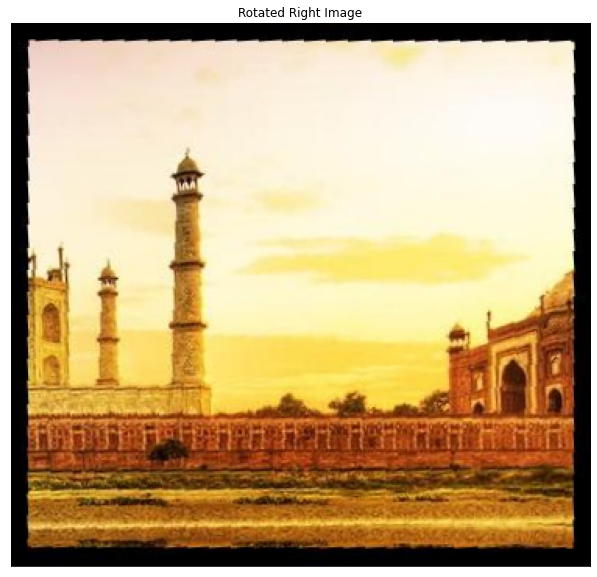

In [23]:
# Rotate the image
img_right = imutils.rotate(img_right, angle=3.925)

# Display the image
fig = plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.title('Rotated Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [24]:
# Convert the images into grayscale
img_left_gs = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
img_centre_gs = cv2.cvtColor(img_centre, cv2.COLOR_BGR2GRAY)
img_right_gs = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

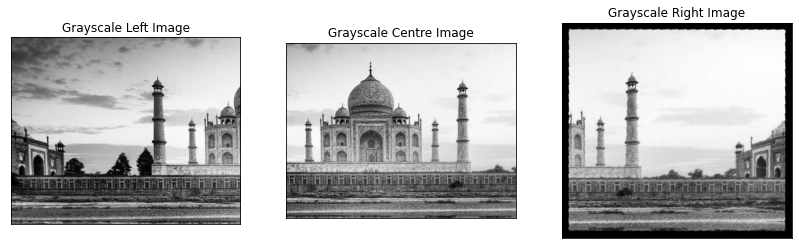

In [25]:
# Display the images
fig = plt.figure(figsize=(14,10))

# Grayscale left image
plt.subplot(131),plt.imshow(img_left_gs, cmap='gray')
plt.title('Grayscale Left Image'), plt.xticks([]), plt.yticks([])

# Grayscale centre image
plt.subplot(132),plt.imshow(img_centre_gs, cmap='gray')
plt.title('Grayscale Centre Image'), plt.xticks([]), plt.yticks([])

# Grayscale right image
plt.subplot(133),plt.imshow(img_right_gs, cmap='gray')
plt.title('Grayscale Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

From the displayed images, we found that the third image have black borders/edges around the actual image that we want to process/stitch. Therefore, we need to trim the image first

# Trim/Crop the right image

We defined a function to trim the image so it is easier when we want to reuse this process for other images (reference from stackoverflow, the link is on the top of this .ipynb)

This function trims (the black borders/edges of) an image using a threshold

The threshold that is used will remove black borders/edges from an image

In [26]:
def trim_black_borders(img):
  # Convert the image to grayscale first
  img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Set the threshold and get the thresholded image
  thresh = cv2.threshold(img_gs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  height, width = thresh.shape

  # Make the bottom 2 rows black (where it is white) by the full width of the image
  thresh[height-3:height, 0:width] = 0

  # Get the bounds of the white pixels
  white = np.where(thresh == 255)
  xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

  # Trim the image at the bounds and adding back the two blackened rows at the bottom
  trimmed_img = img[ymin:ymax+3, xmin:xmax]

  # Return the trimmed image
  return trimmed_img

After we defined the function to trim an image, now we can trim img_right:

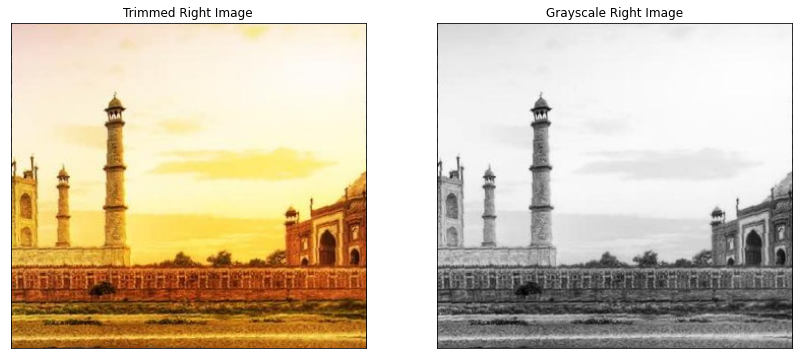

In [27]:
img_right = trim_black_borders(img_right) # Trim the image
img_right_gs = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY) # Get the grayscaled image

# Display the images
fig = plt.figure(figsize=(14,10))

# Trimmed image
plt.subplot(121),plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.title('Trimmed Right Image'), plt.xticks([]), plt.yticks([])

# Grayscaled right image
plt.subplot(122),plt.imshow(img_right_gs, cmap='gray')
plt.title('Grayscale Right Image'), plt.xticks([]), plt.yticks([])

plt.show()

# Define functions for image stitching algorithm

As stated at the top of this file, there are 4 main steps to stitch images. Because we will do the process twice (stitch image 1a and 1b first, then stitch the result with image 1c to get the final result), we will define functions to help us reuse the code for the whole image stitching process

## 1. Detect and compute keypoints and descriptors of the images

To detect and compute keypoints and descriptors of images, we will be using SIFT

First, we need to create/instantiate a SIFT object (We are using SIFT class from opencv that is used to extract keypoints and computing descriptors using SIFT algorithm proposed by D. Lowe)

Then, we use that object to get keypoints and descriptors on both images separately

In [28]:
def get_kp_and_desc(obj_img_gs, target_img_gs):
  # Create the SIFT object
  sift = cv2.SIFT_create()

  # Get keypoints and descriptors for both images separately
  # .detectAndCompute() is used to find keypoints and descriptors in a single step

  # args --> target, mask
  # returns --> keypoints, descriptors
  kp_1, desc_1 = sift.detectAndCompute(obj_img_gs, None)
  kp_2, desc_2 = sift.detectAndCompute(target_img_gs, None)

  # Return the keypoints & descriptors of both images
  return kp_1, desc_1, kp_2, desc_2

The function below is just to display the keypoints found on both images

In [29]:
def display_keypoints(img1, img2, kp1, kp2):
  # Displaying both images with its keypoints
  # Draw the keypoints on the image with color = blue
  img1_keypoints = cv2.drawKeypoints(img1, kp1, 0, (0,0,255))
  img2_keypoints = cv2.drawKeypoints(img2, kp2, 0, (0,0,255))

  # Display
  fig = plt.figure(figsize=(14,10))
  # First image
  plt.subplot(121),plt.imshow(img1_keypoints, cmap = 'gray')
  plt.title('Left Image with Keypoints'), plt.xticks([]), plt.yticks([])
  # Second image
  plt.subplot(122),plt.imshow(img2_keypoints, cmap = 'gray')
  plt.title('Right Image with Keypoints'), plt.xticks([]), plt.yticks([])
  
  plt.show()

## 2. Get the matches of the descriptors

To match images, we need to get the matches from their descriptors

In this assignment, we are using BFMatcher provided by opencv. The way BFMatcher (Brute-Force Matcher) works is by taking the descriptor of 1 feature in the first set and match it with every other feature in the second set using some distance calculation (like Hamming)

The default distance measurement for BFMatcher in opencv is cv2.NORM_L2 which is believed to be good for SIFT

When we try to get matches, we want to get good matches. This can be done by applying ratio test by D. Lowe on the matches that we found

It is a method to filter keypoint matches that we just got by eliminating matches that are not good enough. If the 2 best matches that we got is not different enough, then it is considered not useful enough (information-wise) and we should eliminate it.

The formula to check it is:


```
if best_match < 2nd_best_match * constant:
  the best match is a good enough match
```

In this case, we decided set the constant to be 0.75 (75%)

In [30]:
def get_good_matches(desc_1, desc_2, k=2):
  # Create the BFMatcher object
  # The default distance measurement for cv2.BFMatcher() is..
  # ..cv2.NORM_L2 which is a good one for SIFT
  bf = cv2.BFMatcher() # Use default parameters

  # Next step is to get matches from both images
  bf_matches = bf.knnMatch(desc_1, desc_2, k = k)
  # It will return the 2 best matches so we can apply ratio test..
  # ..proposed by D.Lowe to decide if the match we got is good enough or not

  # Apply ratio test
  good_matches = []
  for pair in bf_matches: # Store the good matches
      try:
          m, n = pair
          if m.distance < (n.distance * 0.75):
              good_matches.append(m) # Add the good match
      except ValueError: pass
  
  # Return the good matches
  return good_matches

## 3. Calculate the homography matrix using RANSAC algorithm

RANSAC (Random sample consensus) algorithm is used to solve a problem which is when the result is bad because there are possible errors while matching. RANSAC algorithm is an outlier detection method. The good matches that provide correct estimation are called inliers and the rest are called outliers

To match features, we usually need to find feature points from the first image and the second image and then find the best matches. These information is usually enough to find objects on both images

To achieve this, we can use .findHomography() function provided by opencv by passing set of points from both images using the RANSAC algorithm. Then, it will find perspective transformation of the object we want to match/find. This function will return a mask that will specify the inliers and outliers points.

But, in this case, we will not be needing the mask. We are only interested in finding the homography matrix

In [31]:
def estimate_homography(kp1, kp2, good_matches):
  # Get the points of both images
  obj_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
  target_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

  # Find the homography which will return the transformation matrix and the mask
  M,_ = cv2.findHomography(target_pts, obj_pts, cv2.RANSAC, 5.0)

  # Return the homography matrix only
  return M

## 4. Apply warping transformation using the homography matrix

To stitch 2 images together, we can amke use of cv2.warpPerspective() that will change the field of view of the image by using the homography matrix we found on the previous step

In the function apply_warp_transformation(), we are taking overlapping areas from both images. In the 'dst' variable, we will only get the right side of the image that is not overlapping. 

The third parameter of cv2.warpPerspective() takes an argument that will set the dimension of the warped image, we will put the combined width of both images as the width, and the height of the left_img as the height)

To fill the left side of the image, we just need to put the left_img there to get the final stitched image from left_img and right_img

In [32]:
def apply_warp_transformation(left_img, right_img, matrix):
  # Warp the perspective and get the right side of the image that is not overlapped
  dst = cv2.warpPerspective(right_img, matrix, (right_img.shape[1] + left_img.shape[1], left_img.shape[0]))
  # Fill the left side of the image
  dst[0:left_img.shape[0],0:left_img.shape[1]] = left_img

  # Return the fully stitched image
  return dst

# Stitch image 1a, 1b, and 1c

## Define a function to stitch 2 images

To reuse the same process easier, we defined a function that compiles all steps to stitch two images into a single function:

In [33]:
def stitch_2_image(left_img, right_img):
  # Get the grayscaled image to be processed
  left_img_gs = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
  right_img_gs = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

  # Detect and compute the keypoints and descriptors
  keypoints_1, descriptors_1, keypoints_2, descriptors_2 = get_kp_and_desc(left_img_gs, right_img_gs)
  
  # Display the keypoints on both images
  display_keypoints(left_img_gs, right_img_gs, keypoints_1, keypoints_2)

  # Get the matches and apply ratio test to get good matches
  good_matches = get_good_matches(descriptors_1, descriptors_2)

  # Get the homography matrix using RANSAC algorithm
  matrix = estimate_homography(keypoints_1, keypoints_2, good_matches)

  # Get the fully stiched image
  stitched_img = apply_warp_transformation(left_img, right_img, matrix)

  # Return the image stitching result
  return stitched_img

## Stitch image 1a and 1b

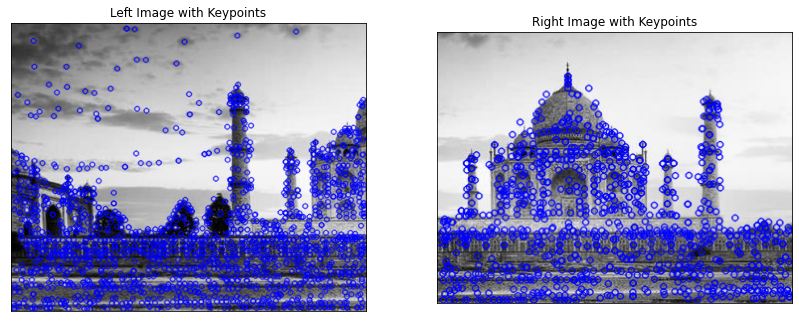

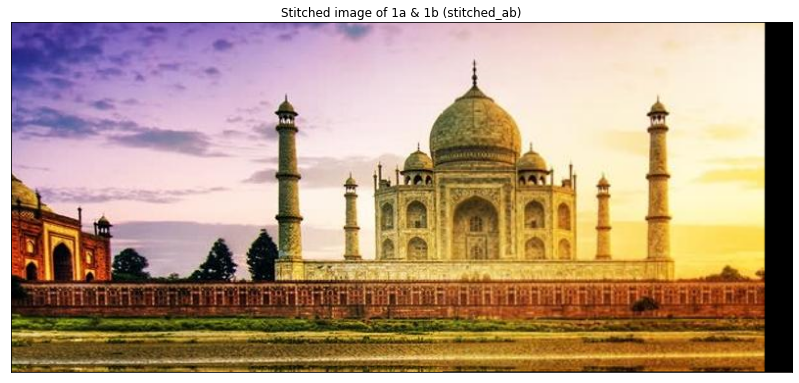

In [34]:
# Stitch 1a and 1b
stitched_ab = stitch_2_image(img_left, img_centre)

# Display the image
# Change from BGR to RGB because we are using matplotlib to display the image
fig = plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(stitched_ab, cv2.COLOR_BGR2RGB))
plt.title('Stitched image of 1a & 1b (stitched_ab)'), plt.xticks([]), plt.yticks([])

plt.show()

From the result above, we can see that there is still a black border/edge left on the right side of the image (we think it could be from the result of combining both images' width when warping the perspective instead of finding the max width between the two images)

Therefore, we need to trim the image just like when we trimmed img_right

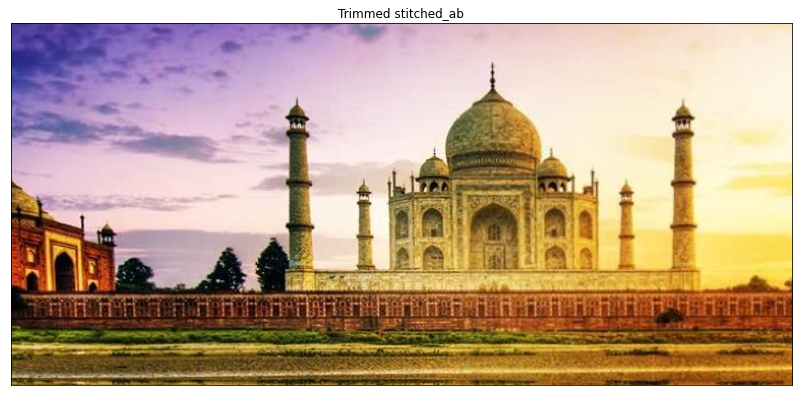

In [35]:
# Trim the image
stitched_ab = trim_black_borders(stitched_ab)

# Display the image
fig = plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(stitched_ab, cv2.COLOR_BGR2RGB))
plt.title('Trimmed stitched_ab'), plt.xticks([]), plt.yticks([])
plt.show()

## Stitch image 1a, 1b, and 1c

We have stitched image 1a and 1b, so what we need to do now is take the result and stitch it with image 1c to obtain the full stitched image of 1a, 1b, and 1c

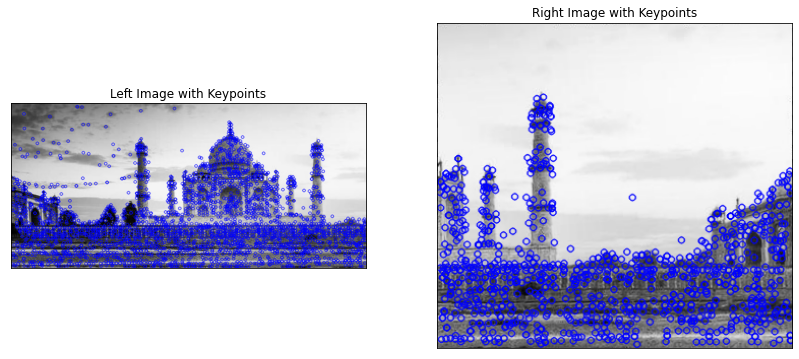

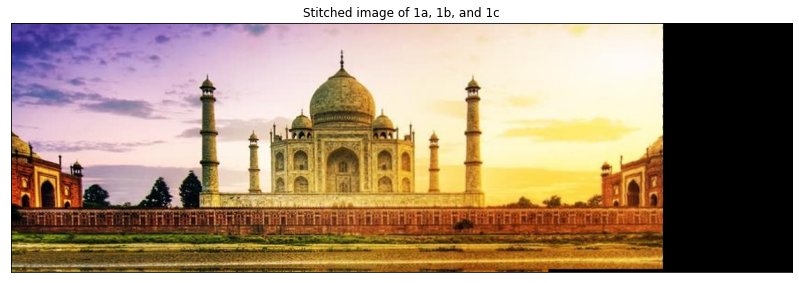

In [36]:
# Get the final stitched image
stitched_abc = stitch_2_image(stitched_ab, img_right)

# Display the image
fig = plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(stitched_abc, cv2.COLOR_BGR2RGB))
plt.title('Stitched image of 1a, 1b, and 1c'), plt.xticks([]), plt.yticks([])

plt.show()

From the result above, we can see that there is still a black border/edge left on the right side of the image just like 'stitched_ab'

Therefore, we need to trim the image again

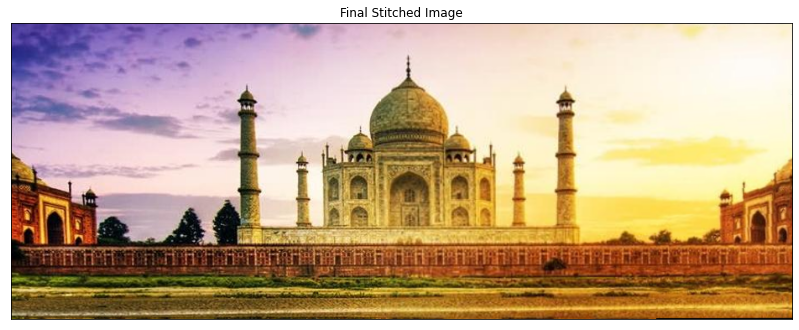

In [37]:
# Trim the image
stitched_abc = trim_black_borders(stitched_abc)

# Display the image
fig = plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(stitched_abc, cv2.COLOR_BGR2RGB))
plt.title('Final Stitched Image'), plt.xticks([]), plt.yticks([])
plt.show()